# Online Retail Dataset: Feature Engineering for Clustering

In this notebook, I'll create some features that will be used to perform
customer segmentation with clustering algorithms.

## Imports

In [1]:
from pathlib import Path
from typing import cast

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.axes import Axes
from mpl_toolkits.mplot3d.axes3d import Axes3D
from pandas.testing import assert_frame_equal
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler

from utils.online_retail import compute_rfm_attributes, compute_total_price, get_clean_data
from utils.outliers import remove_outliers

## Prepare the data

In other notebooks, we've cleaned the original data, and computed the RFM
attributes. We're done with the RFM analysis, but we'll use those results
here. Specifically, we'll utilize recency, frequency and monetary value to
create new features.

Fortunately, we've defined a few functions that we can call to repeat the
steps mentioned above. We can prepare the data again with the aid of the code
that follows.

In [2]:
# Path to original dataset
file_path = Path.cwd().parents[1] / "data" / "online_retail.xlsx"
assert file_path.exists(), f"file doesn't exist: {file_path}"
assert file_path.is_file(), f"not a file: {file_path}"

In [3]:
# Get RFM attributes
df = (
    get_clean_data(file_path)
    .groupby("InvoiceNo", observed=True)
    .apply(compute_total_price, include_groups=False)
    .reset_index()
    .pipe(compute_rfm_attributes)
)

In [4]:
# Remove outliers from Frequency and Monetary
df = remove_outliers(df, ["Frequency", "Monetary"])

Number of observations dropped: 474


In [5]:
df.head(10)

,Recency,Frequency,Monetary
CustomerID,,,
12348,76,4,1797.24
12349,19,1,1757.55
12350,311,1,334.40
12352,37,8,2506.04
12353,205,1,89.00
12354,233,1,1079.40
12355,215,1,459.40
12356,23,3,2811.43
12358,2,2,1168.06


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3864 entries, 12348 to 18287
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    3864 non-null   int64  
 1   Frequency  3864 non-null   int64  
 2   Monetary   3864 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 120.8 KB


## Correlations

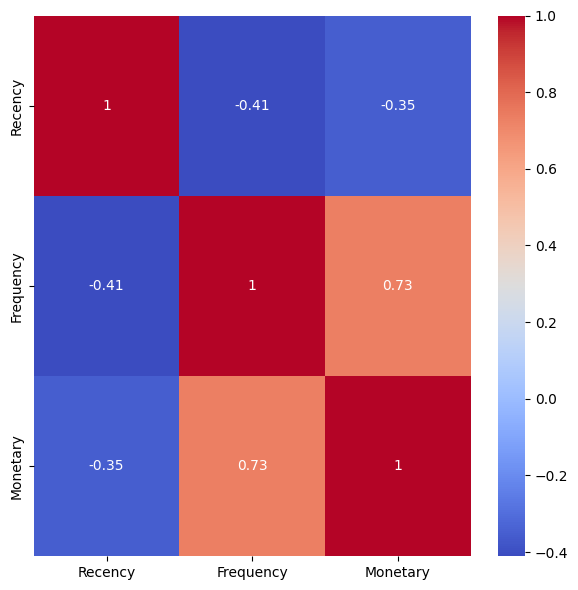

In [7]:
# Correlation between RFM attributes
fig, ax = plt.subplots(figsize=(6.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.heatmap(
    df[["Recency", "Frequency", "Monetary"]].corr(),
    annot=True,
    cmap=mpl.colormaps["coolwarm"],
    ax=ax,
)
plt.show()

In [8]:
# New feature
df["AvgSpent"] = df["Monetary"] / df["Frequency"]
assert df["AvgSpent"].isna().sum() == 0

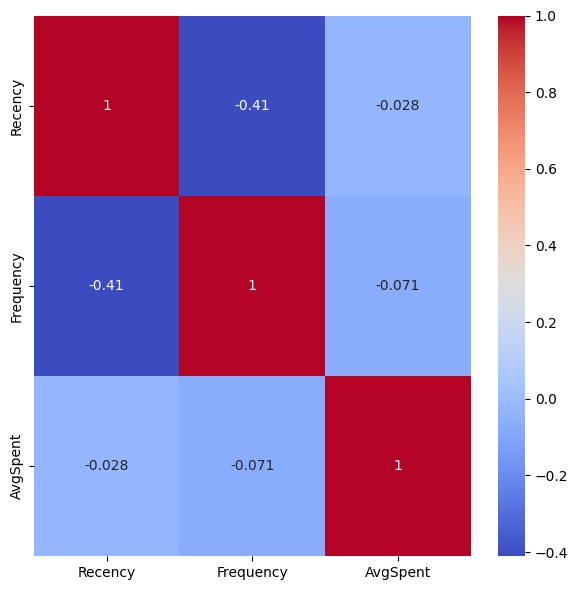

In [9]:
# Correlations with `Monetary` replaced
fig, ax = plt.subplots(figsize=(6.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.heatmap(
    df[["Recency", "Frequency", "AvgSpent"]].corr(),
    annot=True,
    cmap=mpl.colormaps["coolwarm"],
    ax=ax,
)
plt.show()

## Distributions

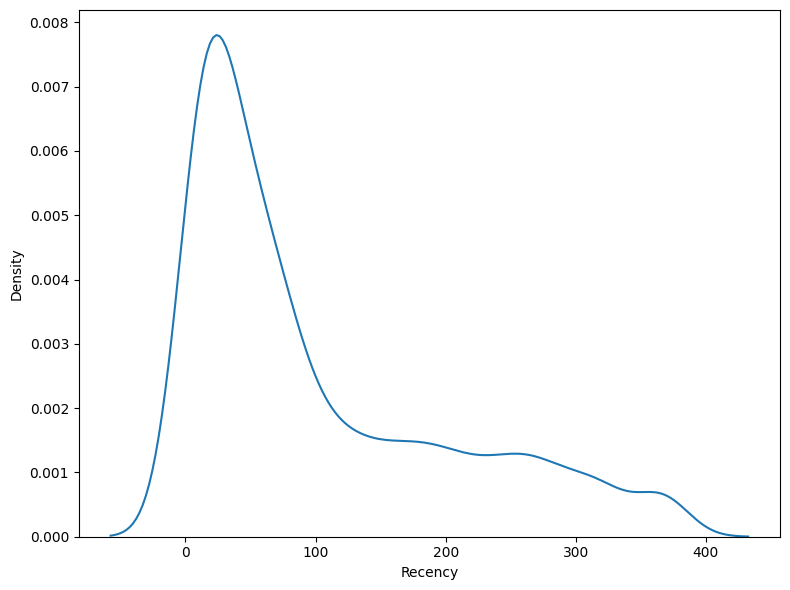

In [10]:
# Recency
fig, ax = plt.subplots(figsize=(8.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.kdeplot(data=df, x="Recency", ax=ax)
plt.show()

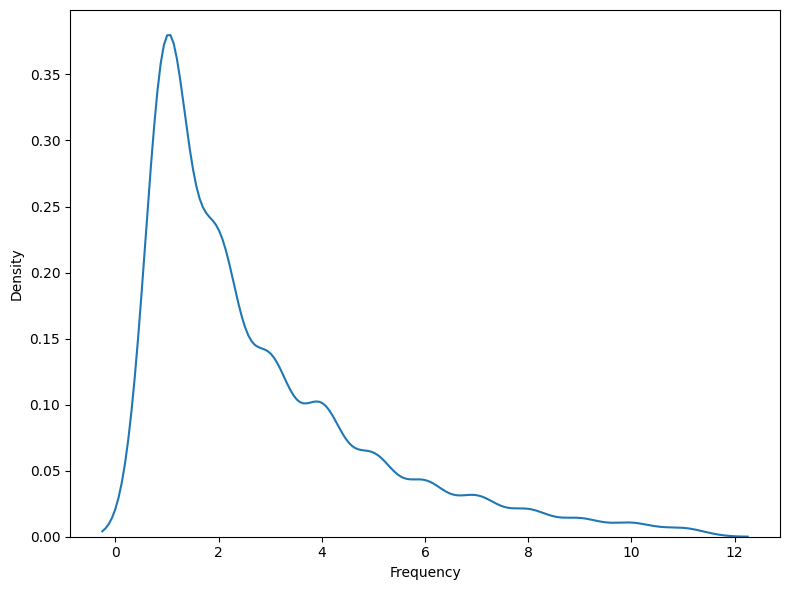

In [11]:
# Frequency
fig, ax = plt.subplots(figsize=(8.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.kdeplot(data=df, x="Frequency", ax=ax)
plt.show()

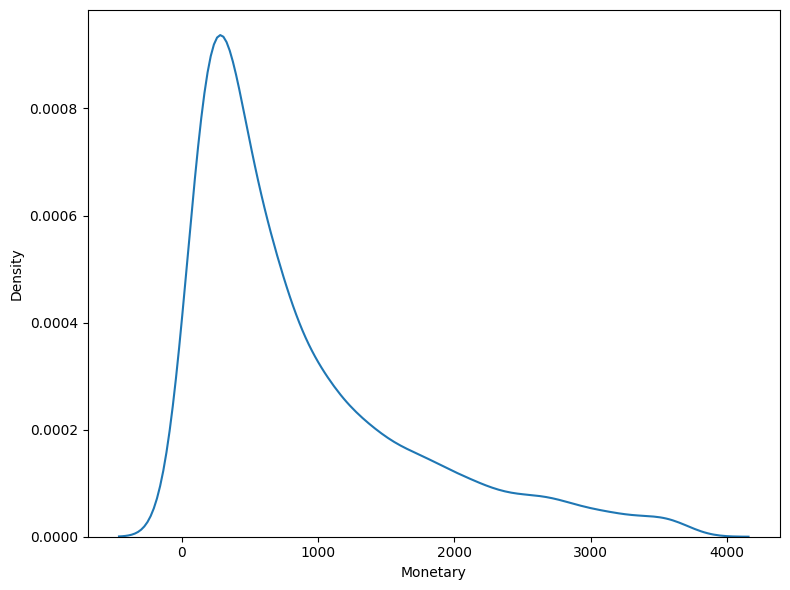

In [12]:
# Monetary
fig, ax = plt.subplots(figsize=(8.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.kdeplot(data=df, x="Monetary", ax=ax)
plt.show()

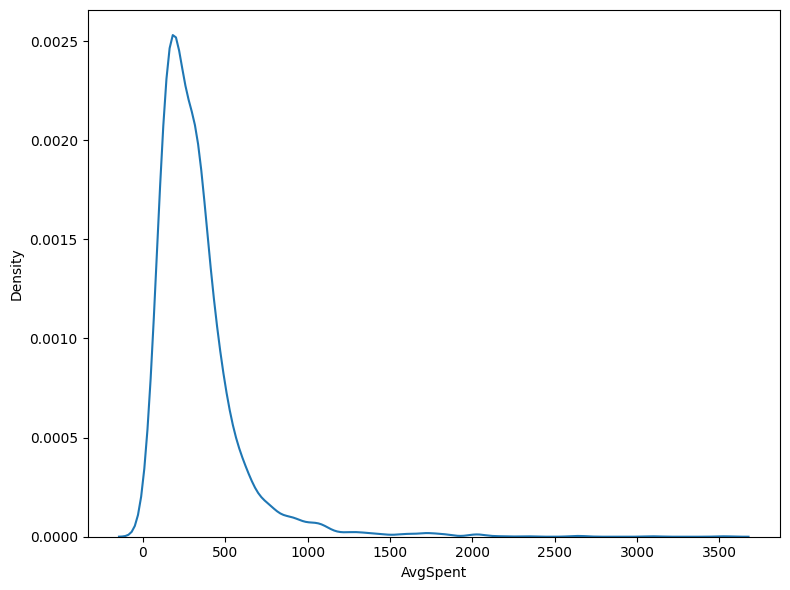

In [13]:
# AvgSpent
fig, ax = plt.subplots(figsize=(8.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.kdeplot(data=df, x="AvgSpent", ax=ax)
plt.show()

## Create features by using transforms
### Power transforms

In [14]:
# Box-Cox transform requires strictly positive input
assert (df["Recency"] > 0).all()
assert (df["Frequency"] > 0).all()
assert (df["Monetary"] > 0).all()
assert (df["AvgSpent"] > 0).all()

In [15]:
# Actual transformation
X = df[["Recency", "Frequency", "Monetary", "AvgSpent"]].to_numpy()
X_new = PowerTransformer(method="box-cox").fit_transform(X)
df = df.assign(
    PTRecency=X_new[:, 0],
    PTFrequency=X_new[:, 1],
    PTMonetary=X_new[:, 2],
    PTAvgSpent=X_new[:, 3],
)
del X_new
df.head()

,Recency,Frequency,Monetary,AvgSpent,PTRecency,PTFrequency,PTMonetary,PTAvgSpent
CustomerID,,,,,,,,
12348,76,4,1797.24,449.310,0.173835,0.948974,1.206388,0.786256
12349,19,1,1757.55,1757.550,-0.864202,-1.128383,1.180741,3.093814
12350,311,1,334.40,334.400,1.542024,-1.128383,-0.549099,0.332557
12352,37,8,2506.04,313.255,-0.398434,1.639797,1.596237,0.234293
12353,205,1,89.00,89.000,1.099392,-1.128383,-1.707361,-1.521242


In [16]:
# New features have mean 0 and variance 1
df[["PTRecency", "PTFrequency", "PTMonetary", "PTAvgSpent"]].agg(["mean", "var"])

,PTRecency,PTFrequency,PTMonetary,PTAvgSpent
mean,2.022767e-16,-2.629597e-16,-2.427320e-16,-4.633974e-16
var,1.000259e+00,1.000259e+00,1.000259e+00,1.000259e+00


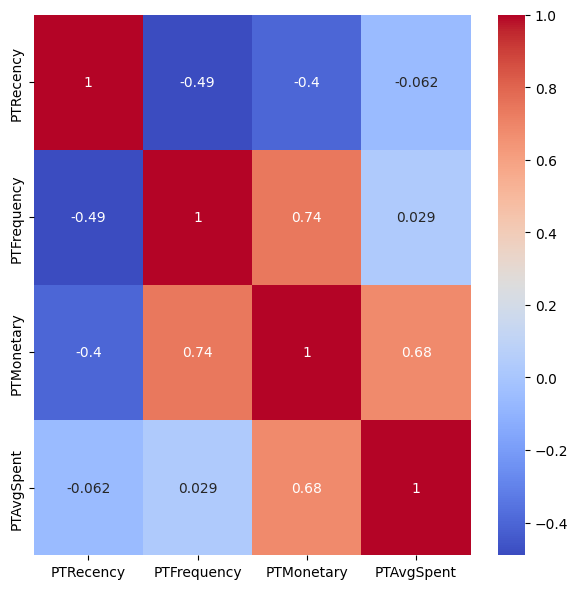

In [17]:
# Correlations
fig, ax = plt.subplots(figsize=(6.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.heatmap(
    df[["PTRecency", "PTFrequency", "PTMonetary", "PTAvgSpent"]].corr(),
    annot=True,
    cmap=mpl.colormaps["coolwarm"],
    ax=ax,
)
plt.show()

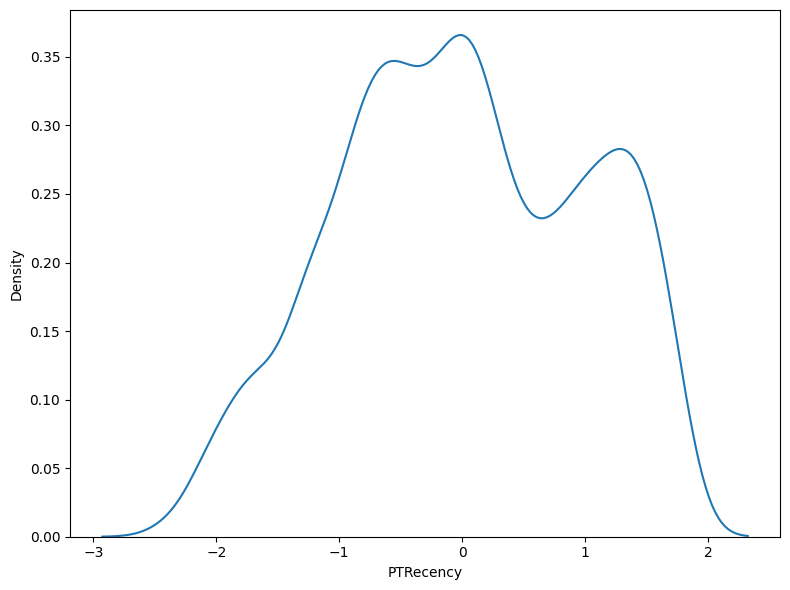

In [18]:
# Distribution of PTRecency: NOT Gaussian-like
fig, ax = plt.subplots(figsize=(8.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.kdeplot(data=df, x="PTRecency", ax=ax)
plt.show()

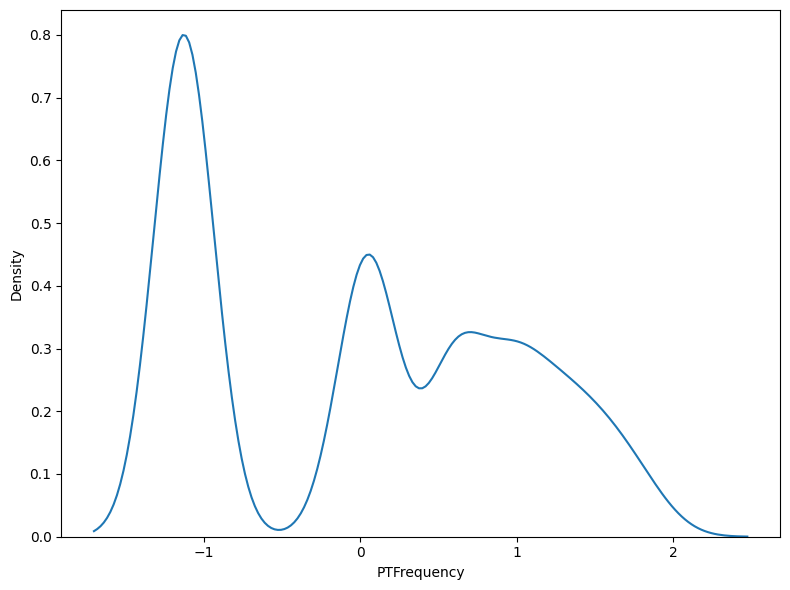

In [19]:
# Distribution of PTFrequency: NOT Gaussian-like
fig, ax = plt.subplots(figsize=(8.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.kdeplot(data=df, x="PTFrequency", ax=ax)
plt.show()

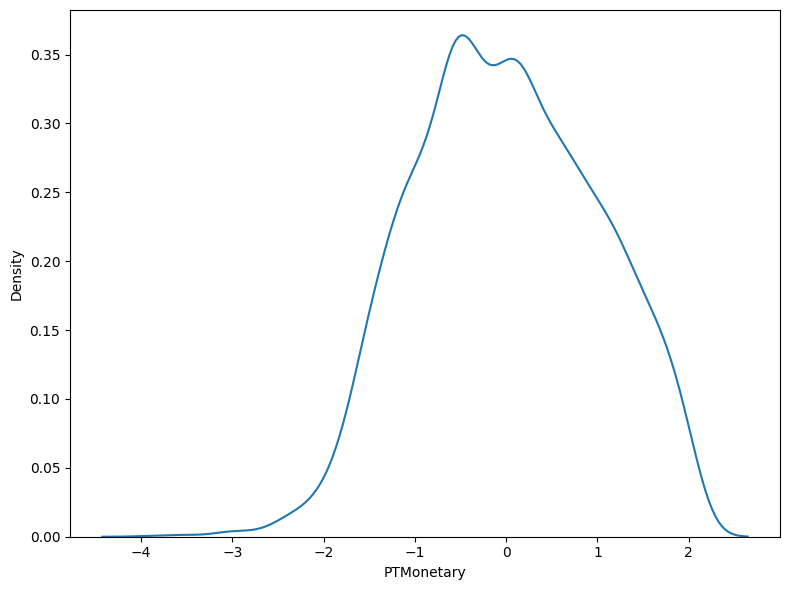

In [20]:
# Distribution of PTMonetary: Almost Gaussian-like
fig, ax = plt.subplots(figsize=(8.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.kdeplot(data=df, x="PTMonetary", ax=ax)
plt.show()

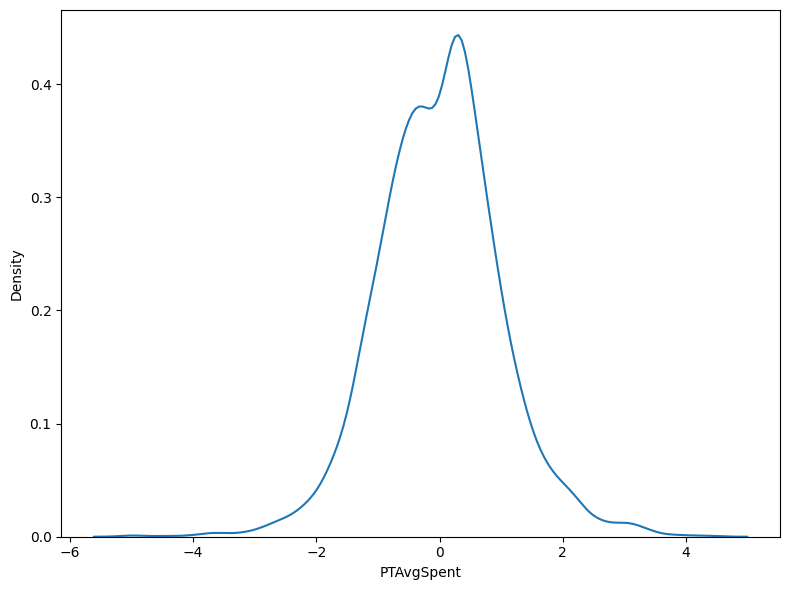

In [21]:
# Distribution of PTAvgSpent: Gaussian-like!!!
fig, ax = plt.subplots(figsize=(8.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.kdeplot(data=df, x="PTAvgSpent", ax=ax)
plt.show()

### Quantile transform

In [22]:
qt = QuantileTransformer(n_quantiles=100, output_distribution="normal", random_state=333)
X_new = qt.fit_transform(X)
df = df.assign(
    QTRecency=X_new[:, 0],
    QTFrequency=X_new[:, 1],
    QTMonetary=X_new[:, 2],
    QTAvgSpent=X_new[:, 3],
)
del qt
del X_new
df.head()

,Recency,Frequency,Monetary,AvgSpent,PTRecency,PTFrequency,PTMonetary,PTAvgSpent,QTRecency,QTFrequency,QTMonetary,QTAvgSpent
CustomerID,,,,,,,,,,,,
12348,76,4,1797.24,449.310,0.173835,0.948974,1.206388,0.786256,0.199654,0.747859,1.085899,0.889380
12349,19,1,1757.55,1757.550,-0.864202,-1.128383,1.180741,3.093814,-0.799083,-5.199338,1.059397,2.392103
12350,311,1,334.40,334.400,1.542024,-1.128383,-0.549099,0.332557,1.571091,-5.199338,-0.473483,0.357621
12352,37,8,2506.04,313.255,-0.398434,1.639797,1.596237,0.234293,-0.321971,1.807354,1.524281,0.226299
12353,205,1,89.00,89.000,1.099392,-1.128383,-1.707361,-1.521242,0.895954,-5.199338,-1.877739,-1.618103


In [23]:
# New features need to be standardized
df[["QTRecency", "QTFrequency", "QTMonetary", "QTAvgSpent"]].agg(["mean", "var"])

,QTRecency,QTFrequency,QTMonetary,QTAvgSpent
mean,-0.000323,-1.598067,0.000460,-0.001769
var,1.152130,8.473343,1.006389,0.990429


In [24]:
# Standardize new features
X = df[["QTRecency", "QTFrequency", "QTMonetary", "QTAvgSpent"]].to_numpy()
X_new = StandardScaler().fit_transform(X)
df = df.assign(
    QTRecency=X_new[:, 0],
    QTFrequency=X_new[:, 1],
    QTMonetary=X_new[:, 2],
    QTAvgSpent=X_new[:, 3],
)
del X
del X_new
df.head()

,Recency,Frequency,Monetary,AvgSpent,PTRecency,PTFrequency,PTMonetary,PTAvgSpent,QTRecency,QTFrequency,QTMonetary,QTAvgSpent
CustomerID,,,,,,,,,,,,
12348,76,4,1797.24,449.310,0.173835,0.948974,1.206388,0.786256,0.186332,0.806015,1.082128,0.895561
12349,19,1,1757.55,1757.550,-0.864202,-1.128383,1.180741,3.093814,-0.744255,-1.237327,1.055707,2.405722
12350,311,1,334.40,334.400,1.542024,-1.128383,-0.549099,0.332557,1.464185,-1.237327,-0.472497,0.361170
12352,37,8,2506.04,313.255,-0.398434,1.639797,1.596237,0.234293,-0.299700,1.170037,1.519173,0.229197
12353,205,1,89.00,89.000,1.099392,-1.128383,-1.707361,-1.521242,0.835118,-1.237327,-1.872470,-1.624335


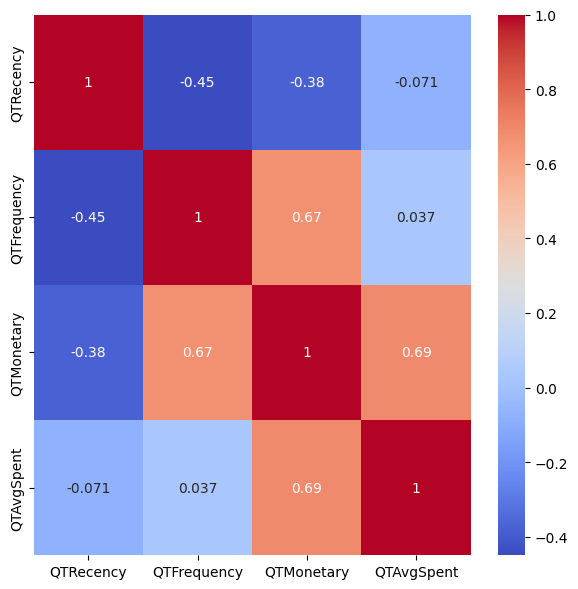

In [25]:
# Correlations
fig, ax = plt.subplots(figsize=(6.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.heatmap(
    df[["QTRecency", "QTFrequency", "QTMonetary", "QTAvgSpent"]].corr(),
    annot=True,
    cmap=mpl.colormaps["coolwarm"],
    ax=ax,
)
plt.show()

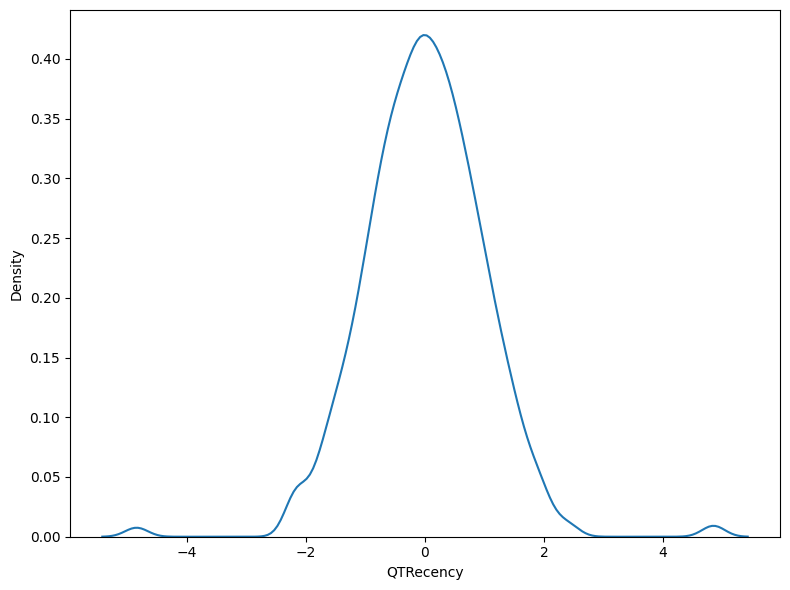

In [26]:
# Distribution of QTRecency: Gaussian-like!!!
fig, ax = plt.subplots(figsize=(8.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.kdeplot(data=df, x="QTRecency", ax=ax)
plt.show()

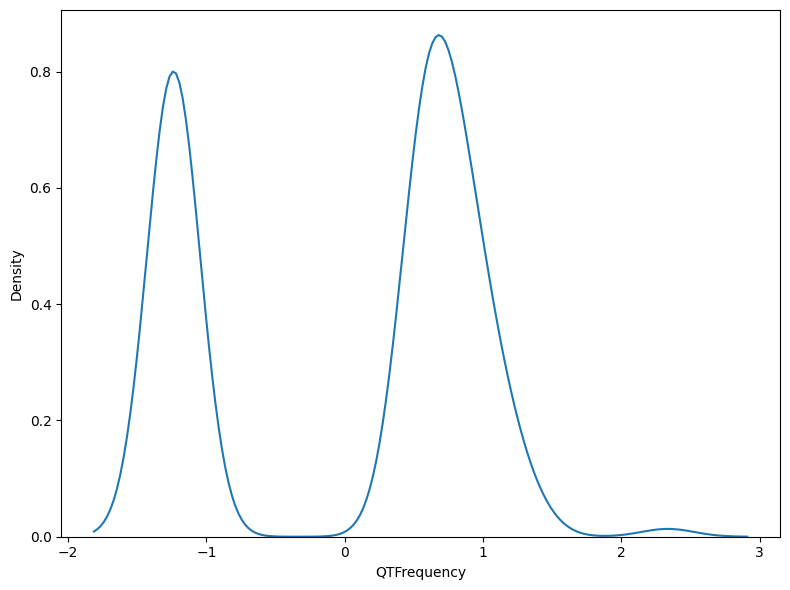

In [27]:
# Distribution of QTFrequency: NOT Gaussian-like
fig, ax = plt.subplots(figsize=(8.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.kdeplot(data=df, x="QTFrequency", ax=ax)
plt.show()

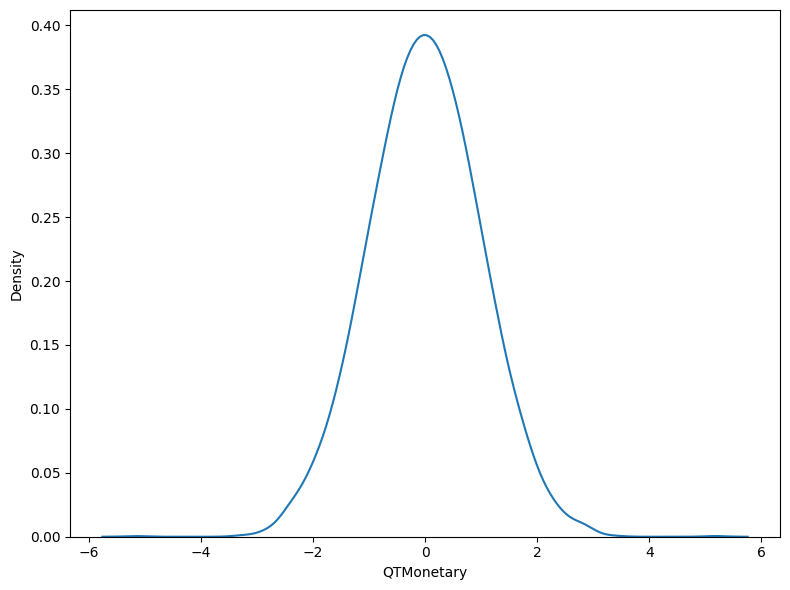

In [28]:
# Distribution of QTMonetary: Gaussian-like!!!
fig, ax = plt.subplots(figsize=(8.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.kdeplot(data=df, x="QTMonetary", ax=ax)
plt.show()

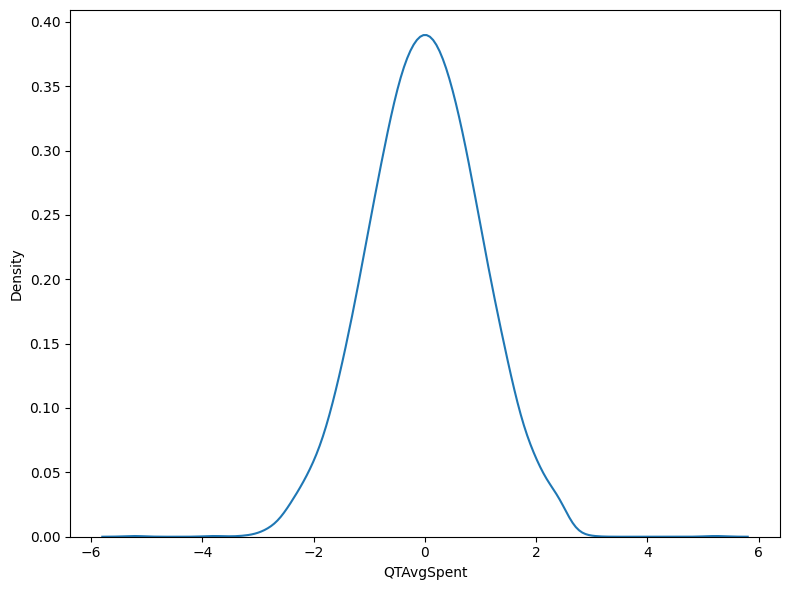

In [29]:
# Distribution of QTAvgSpent: Gaussian-like!!!
fig, ax = plt.subplots(figsize=(8.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.kdeplot(data=df, x="QTAvgSpent", ax=ax)
plt.show()

## 3D Plots

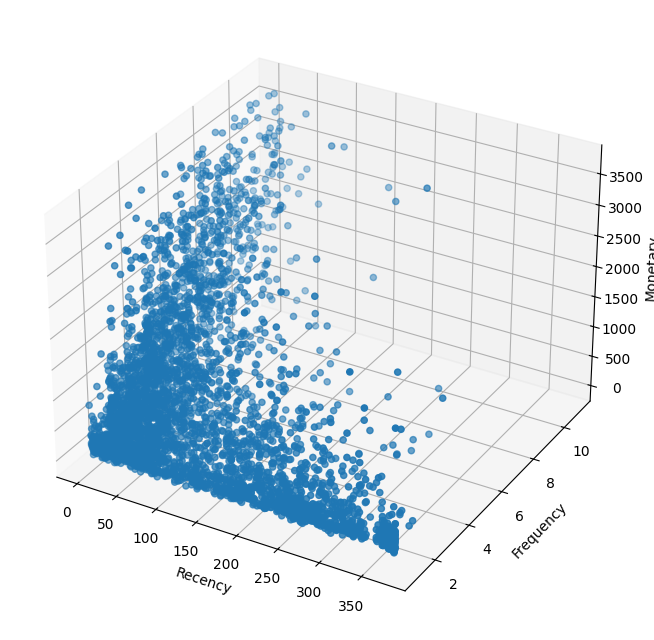

In [30]:
# For comparison, plot "original" features
fig = plt.figure(figsize=(8.0, 6.5), layout="tight")
ax = fig.add_subplot(projection="3d")
ax = cast(Axes3D, ax)
ax.scatter(df.Recency, df.Frequency, df.Monetary)
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
plt.show()

Features yielded by power transform:

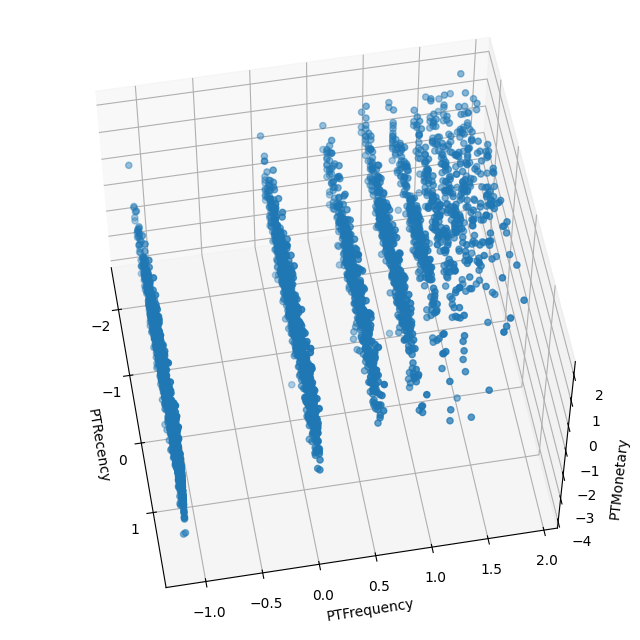

In [31]:
fig = plt.figure(figsize=(8.0, 6.5), layout="tight")
ax = fig.add_subplot(projection="3d")
ax = cast(Axes3D, ax)
ax.scatter(df.PTRecency, df.PTFrequency, df.PTMonetary)
ax.view_init(elev=55.0, azim=-10.0, roll=0.0)
ax.set_xlabel("PTRecency")
ax.set_ylabel("PTFrequency")
ax.set_zlabel("PTMonetary")
plt.show()

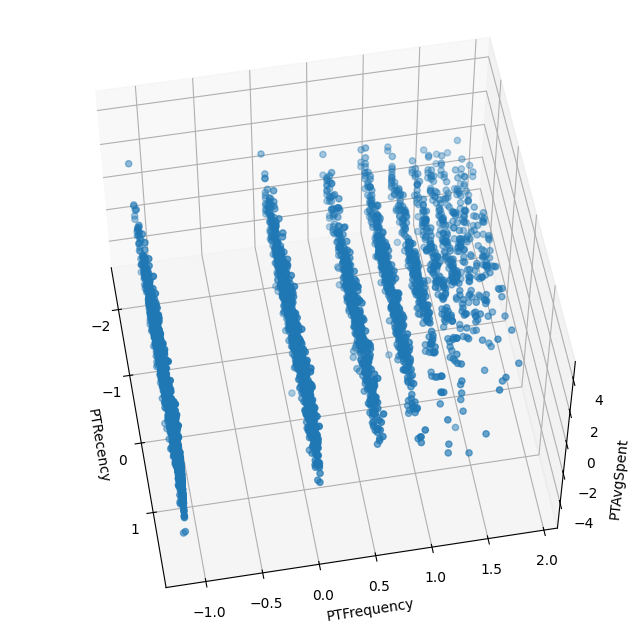

In [32]:
fig = plt.figure(figsize=(8.0, 6.5), layout="tight")
ax = fig.add_subplot(projection="3d")
ax = cast(Axes3D, ax)
ax.scatter(df.PTRecency, df.PTFrequency, df.PTAvgSpent)
ax.view_init(elev=55.0, azim=-10.0, roll=0.0)
ax.set_xlabel("PTRecency")
ax.set_ylabel("PTFrequency")
ax.set_zlabel("PTAvgSpent")
plt.show()

Features yielded by quantile transform:

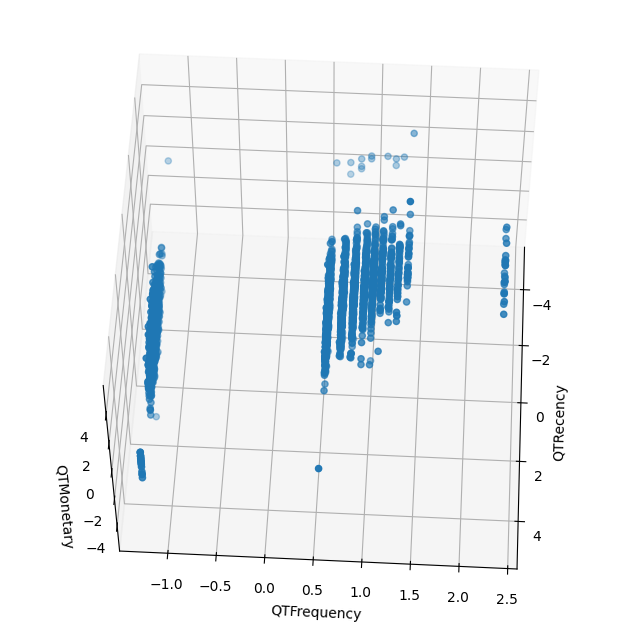

In [33]:
fig = plt.figure(figsize=(8.0, 6.5), layout="tight")
ax = fig.add_subplot(projection="3d")
ax = cast(Axes3D, ax)
ax.scatter(df.QTRecency, df.QTFrequency, df.QTMonetary)
ax.view_init(elev=55.0, azim=3.0, roll=0.0)
ax.set_xlabel("QTRecency")
ax.set_ylabel("QTFrequency")
ax.set_zlabel("QTMonetary")
plt.show()

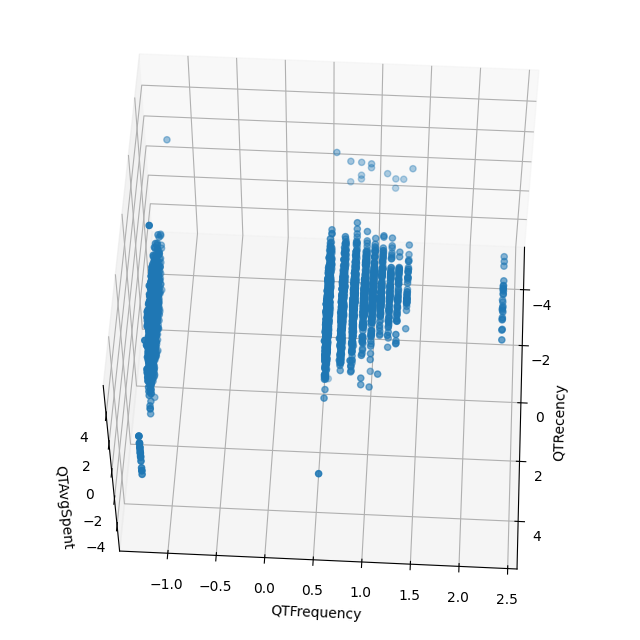

In [34]:
fig = plt.figure(figsize=(8.0, 6.5), layout="tight")
ax = fig.add_subplot(projection="3d")
ax = cast(Axes3D, ax)
ax.scatter(df.QTRecency, df.QTFrequency, df.QTAvgSpent)
ax.view_init(elev=55.0, azim=3.0, roll=0.0)
ax.set_xlabel("QTRecency")
ax.set_ylabel("QTFrequency")
ax.set_zlabel("QTAvgSpent")
plt.show()

Based on the above figures, the quantile transform features seem the most
useful. After all, in the corresponding plot, we can see a few clusters quite
clearly.

## Save features

In [35]:
# Just checking everything's OK
df.head()

,Recency,Frequency,Monetary,AvgSpent,PTRecency,PTFrequency,PTMonetary,PTAvgSpent,QTRecency,QTFrequency,QTMonetary,QTAvgSpent
CustomerID,,,,,,,,,,,,
12348,76,4,1797.24,449.310,0.173835,0.948974,1.206388,0.786256,0.186332,0.806015,1.082128,0.895561
12349,19,1,1757.55,1757.550,-0.864202,-1.128383,1.180741,3.093814,-0.744255,-1.237327,1.055707,2.405722
12350,311,1,334.40,334.400,1.542024,-1.128383,-0.549099,0.332557,1.464185,-1.237327,-0.472497,0.361170
12352,37,8,2506.04,313.255,-0.398434,1.639797,1.596237,0.234293,-0.299700,1.170037,1.519173,0.229197
12353,205,1,89.00,89.000,1.099392,-1.128383,-1.707361,-1.521242,0.835118,-1.237327,-1.872470,-1.624335


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3864 entries, 12348 to 18287
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Recency      3864 non-null   int64  
 1   Frequency    3864 non-null   int64  
 2   Monetary     3864 non-null   float64
 3   AvgSpent     3864 non-null   float64
 4   PTRecency    3864 non-null   float64
 5   PTFrequency  3864 non-null   float64
 6   PTMonetary   3864 non-null   float64
 7   PTAvgSpent   3864 non-null   float64
 8   QTRecency    3864 non-null   float64
 9   QTFrequency  3864 non-null   float64
 10  QTMonetary   3864 non-null   float64
 11  QTAvgSpent   3864 non-null   float64
dtypes: float64(10), int64(2)
memory usage: 392.4 KB


In [37]:
# Save to CSV
out_file = file_path.parent / "clustering_features.csv"
df.to_csv(out_file, index=True)

## Summarizing through functions

In [38]:
def get_original_features(
    file_path: Path,
    outlier_cols: str | list[str] | None = None,
) -> pd.DataFrame:
    df = (
        get_clean_data(file_path)
        .groupby("InvoiceNo", observed=True)
        .apply(compute_total_price, include_groups=False)
        .reset_index()
        .pipe(compute_rfm_attributes)
        .assign(AvgSpent=lambda x: x.Monetary / x.Frequency)
    )
    return df if outlier_cols is None else remove_outliers(df, outlier_cols)

In [39]:
def add_power_transform_features(df: pd.DataFrame) -> pd.DataFrame:
    X = df[["Recency", "Frequency", "Monetary", "AvgSpent"]].to_numpy()  # noqa: N806
    X_new = PowerTransformer(method="box-cox").fit_transform(X)  # noqa: N806
    return df.assign(
        PTRecency=X_new[:, 0],
        PTFrequency=X_new[:, 1],
        PTMonetary=X_new[:, 2],
        PTAvgSpent=X_new[:, 3],
    )

In [40]:
def add_quantile_transform_features(df: pd.DataFrame) -> pd.DataFrame:
    X = df[["Recency", "Frequency", "Monetary", "AvgSpent"]].to_numpy()  # noqa: N806
    qt = QuantileTransformer(n_quantiles=100, output_distribution="normal", random_state=333)
    X_new_1 = qt.fit_transform(X)  # noqa: N806
    X_new_2 = StandardScaler().fit_transform(X_new_1)  # noqa: N806
    return df.assign(
        QTRecency=X_new_2[:, 0],
        QTFrequency=X_new_2[:, 1],
        QTMonetary=X_new_2[:, 2],
        QTAvgSpent=X_new_2[:, 3],
    )

In [41]:
# Quick check
df_funcs = (
    get_original_features(
        Path.cwd().parents[1] / "data" / "online_retail.xlsx",
        outlier_cols=["Frequency", "Monetary"],
    )
    .pipe(add_power_transform_features)
    .pipe(add_quantile_transform_features)
)
assert_frame_equal(df_funcs, df)
del df_funcs

Number of observations dropped: 474


In [42]:
def compute_and_save_features(
    file_path: Path,
    outlier_cols: str | list[str] | None = None,
) -> None:
    df = (
        get_original_features(file_path, outlier_cols)
        .pipe(add_power_transform_features)
        .pipe(add_quantile_transform_features)
    )
    df.to_csv(file_path.parent / "clustering_features.csv", index=True)

In [43]:
compute_and_save_features(
    Path.cwd().parents[1] / "data" / "online_retail.xlsx",
    outlier_cols=["Frequency", "Monetary"],
)

Number of observations dropped: 474
